In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [11]:
# Load the dataset
data = pd.read_csv('/Users/paraggupta/Desktop/projects/CO2_ForecastAnalysis/data/data2.csv')

# Convert 'Time' column to datetime
data['Time'] = pd.to_datetime(data['Time'])

# Extract features and target variable
# Let's assume we are predicting 'Temperature (degC)'
features = data[[ 'Humidity (%)', 'Longitude', 'Latitude', 'Barometric Pressure (mBar)','Temperature (degC)']].values
target = data['CO2 (PPM)'].values

# Convert data to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
target = torch.tensor(target, dtype=torch.float32)

# Reshape data for LSTM [samples, time steps, features]
features = features.view(features.shape[0], 1, features.shape[1])
target = target.view(target.shape[0], 1)


In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.target[index]

# Create dataset and dataloader
dataset = TimeSeriesDataset(features, target)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = features.shape[2]
hidden_size = 50
num_layers = 2
output_size = 1

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)


In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [19]:
num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    for features_batch, target_batch in dataloader:
        # Move tensors to the configured device
        features_batch = features_batch.to(model.fc.weight.device)
        target_batch = target_batch.to(model.fc.weight.device)
        
        # Forward pass
        outputs = model(features_batch)
        loss = criterion(outputs, target_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #if (epoch+1) % 10 == 0:
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete')


Training complete


PREDICTION

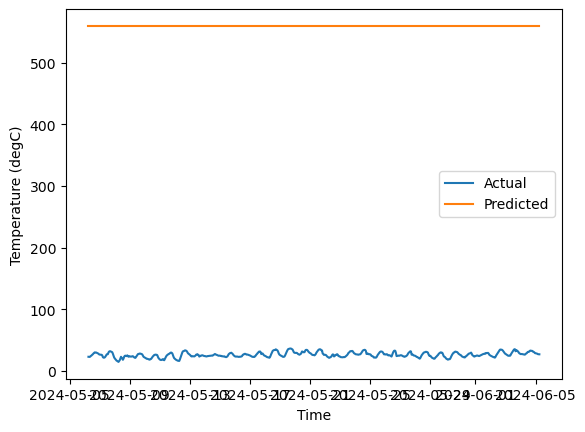

In [20]:
# Switch the model to evaluation mode
model.eval()

# Predict on the training data
with torch.no_grad():
    predictions = model(features.to(model.fc.weight.device)).cpu().numpy()

# Plot the predictions
plt.plot(data['Time'], data['Temperature (degC)'].values, label='Actual')
plt.plot(data['Time'], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()
